In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [427]:
# Laste poll-of-polls data
df = pd.read_csv("../data/all_polls.csv", sep=",", encoding='ISO-8859-1')

In [428]:
# Convert to datetime and set the date to the end of the month
df["Dato"] = pd.to_datetime(df["Dato"])

In [429]:
# Sort values and set index
df = df.sort_values("Dato")
df.set_index("Dato", inplace=True)

In [430]:
df_en=df[["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]]

In [437]:
df

,Måling,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,Year,Month
Dato,,,,,,,,,,,,,
2008-01-09,Verian/TV2,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0,2008,1
2008-01-10,Sentio/BT,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0,2008,1
2008-01-18,Norstat/NRK,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0,2008,1
2008-01-21,InFact/VG,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0,2008,1
2008-01-21,Respons/Aftenp,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05,Verian/TV2,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8,2025,9
2025-09-05,Norstat/NRK / VL / Dagbl.,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1,2025,9
2025-09-06,Norfakta/Nat. / KK,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9,2025,9


In [431]:
df_en

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
Dato,,,,,,,,,,
2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-09-05,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8
2025-09-05,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1
2025-09-06,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9


In [438]:
# --- 2) Aggregate to quarter-day bins ---
# Resample to 6-hour bins ("6H")
quarter_day = df_en.resample("6H").mean()

# Optional: add how many original obs contributed to each bin
counts = df_en.resample("6H").size().rename("count_per_bin")
quarter_day = quarter_day.join(counts)

# --- 3) Reindex to a complete 6-hour grid ---
all_bins = pd.date_range(quarter_day.index.min(), quarter_day.index.max(), freq="6H")
quarter_day = quarter_day.reindex(all_bins)

# --- 4) Fill missing values with previous day's average ---
# Group by calendar date and take mean (daily average)
daily_avg = quarter_day.resample("1D").mean()

# For each missing bin, fill with previous day's daily average
filled = quarter_day.copy()
for ts, row in filled.iterrows():
    if row.isna().any():  # if any NaN in this bin
        prev_day = (ts - pd.Timedelta(days=1)).normalize()
        if prev_day in daily_avg.index:
            filled.loc[ts] = daily_avg.loc[prev_day]
        else:
            # If no previous day exists, forward-fill from last known
            filled.loc[ts] = filled.loc[:ts].ffill().iloc[-1]

# --- 5) Mark imputed bins (optional, good for model input) ---
was_missing = quarter_day.isna().any(axis=1)
filled["was_imputed"] = was_missing.astype(int)

# --- 6) Re-normalize to ensure sum = 100 ---
cols = [c for c in filled.columns if c not in ["count_per_bin", "was_imputed"]]
sums = filled[cols].sum(axis=1)
filled[cols] = filled[cols].div(sums, axis=0).mul(100)


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_27224\3856729319.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  quarter_day = df_en.resample("6H").mean()
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_27224\3856729319.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  counts = df_en.resample("6H").size().rename("count_per_bin")
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_27224\3856729319.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_bins = pd.date_range(quarter_day.index.min(), quarter_day.index.max(), freq="6H")
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_27224\3856729319.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

In [439]:
filled

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,count_per_bin,was_imputed
2008-01-09 00:00:00,33.607400,14.491264,23.843782,7.297020,6.577595,8.016444,6.166495,0.000000,0.000000,0.000000,1.0,0
2008-01-09 06:00:00,33.607400,14.491264,23.843782,7.297020,6.577595,8.016444,6.166495,0.000000,0.000000,0.000000,0.0,1
2008-01-09 12:00:00,33.607400,14.491264,23.843782,7.297020,6.577595,8.016444,6.166495,0.000000,0.000000,0.000000,0.0,1
2008-01-09 18:00:00,33.607400,14.491264,23.843782,7.297020,6.577595,8.016444,6.166495,0.000000,0.000000,0.000000,0.0,1
2008-01-10 00:00:00,31.714876,16.735537,24.173554,8.367769,5.578512,5.785124,7.644628,0.000000,0.000000,0.000000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05 00:00:00,27.063532,14.657329,20.710355,5.902951,6.003002,4.202101,4.102051,6.803402,6.103052,4.452226,2.0,0
2025-09-05 06:00:00,28.014007,13.906953,20.310155,6.903452,5.552776,5.002501,4.202101,6.103052,5.852926,4.152076,0.5,1
2025-09-05 12:00:00,28.014007,13.906953,20.310155,6.903452,5.552776,5.002501,4.202101,6.103052,5.852926,4.152076,0.5,1
2025-09-05 18:00:00,28.014007,13.906953,20.310155,6.903452,5.552776,5.002501,4.202101,6.103052,5.852926,4.152076,0.5,1


In [440]:
df_en=filled[[

In [441]:
#n_timesteps = 5   # past steps to look at
#n_future = 12      # steps into the future we want to predict
n_features = df_en.shape[1]  
series_names = df_en.columns

In [394]:
n_features

10

In [395]:
#n_timesteps = 1  # number of past days to look at
#X, y = [], []

#for i in range(len(df_en) - n_timesteps):
#    X.append(df_en.values[i:i+n_timesteps, :])  
#    y.append(df_en.values[i+n_timesteps, :])  #

#X = np.array(X)  # shape: (num_samples, n_timesteps, 9)
#y = np.array(y)  # shape: (num_samples, 9)

In [442]:
def windowed_dataset_multivariate(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a tf.data.Dataset for multivariate time series.
    
    series: numpy array or tf.Tensor with shape (num_timesteps, num_features)
    window_size: number of timesteps in the input window
    batch_size: training batch size
    shuffle_buffer: buffer size for shuffling
    """
    # Make a Dataset of timesteps
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Create sliding windows of length (window_size + 1)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Convert each window into a batch tensor
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Shuffle windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Split into (input, label): 
    # inputs = first window_size steps, labels = last step
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [443]:
window_size = 15
batch_size = 24
shuffle_buffer = 15

dataset = windowed_dataset_multivariate(
    df_en.values, window_size, batch_size, shuffle_buffer
)

In [398]:
#split = int(len(X) * 0.98)
#X_train, X_test = X[:split], X[split:]
#y_train, y_test = y[:split], y[split:]

In [444]:
model_tune = Sequential([
    tf.keras.Input(shape=(window_size, n_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(n_features),
    Lambda(lambda x: tf.nn.softmax(x) * 100)
])

In [445]:
model_tune = Sequential([
    tf.keras.Input(shape=(window_size, n_features)),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),   # single LSTM layer is often enough
    Dense(32, activation='relu'),       # small hidden layer
    Dense(n_features),
    Lambda(lambda x: tf.nn.softmax(x) * 100)
])

In [446]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan - learning_rate: 1.0000e-06
Epoch 2/100
  18/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: nan

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: nan - learning_rate: 1.1220e-06
Epoch 3/100
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: nan - learning_rate: 1.2589e-06
Epoch 4/100
 125/1075 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: nan

KeyboardInterrupt: 

(1e-08, 0.001, 0.0, 10.0)

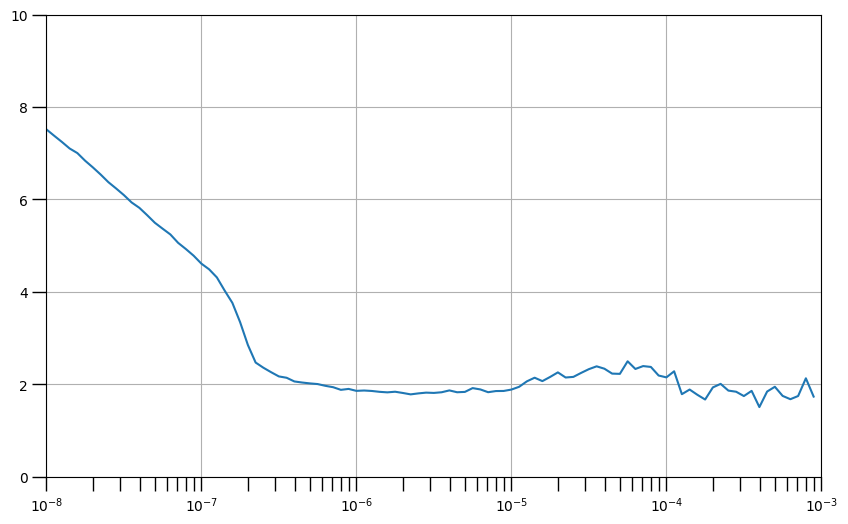

In [402]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 10])

In [447]:
tf.keras.backend.clear_session()

model = Sequential([
    tf.keras.Input(shape=(window_size, n_features)),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),   # single LSTM layer is often enough
    Dense(32, activation='relu'),       # small hidden layer
    Dense(n_features),
    Lambda(lambda x: tf.nn.softmax(x) * 100)
])

In [404]:
# Set the learning r6te
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [410]:
split = int(len(df_en) * 0.90)
train_data = df_en.values[:split]
val_data   = df_en.values[split:]

train_dataset = windowed_dataset_multivariate(train_data, window_size, batch_size, shuffle_buffer)
val_dataset   = windowed_dataset_multivariate(val_data,   window_size, batch_size, shuffle_buffer)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5950 - mae: 2.0285 - val_loss: 2.2701 - val_mae: 2.7217
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5987 - mae: 2.0326 - val_loss: 2.2707 - val_mae: 2.7221
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6067 - mae: 2.0417 - val_loss: 2.2714 - val_mae: 2.7229
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5979 - mae: 2.0331 - val_loss: 2.2717 - val_mae: 2.7231
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6135 - mae: 2.0471 - val_loss: 2.2712 - val_mae: 2.7225
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6003 - mae: 2.0338 - val_loss: 2.2699 - val_mae: 2.7212
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6157 - mae: 2.0503 - val_loss: 2.2710 - val_mae: 2.7223
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5906 - mae: 2.0254 - val_loss: 2.2717 - val_mae: 2.7231
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6018 - mae: 

In [411]:
# Collect all batches from tf.data.Dataset into arrays
X_test, y_test = [], []
for X_batch, y_batch in val_dataset:  # or test_dataset if you split
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print("X_test shape:", X_test.shape)  # (num_test, window_size, 9)
print("y_test shape:", y_test.shape)  # (num_test, 9)


X_test shape: (172, 15, 10)
y_test shape: (172, 10)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


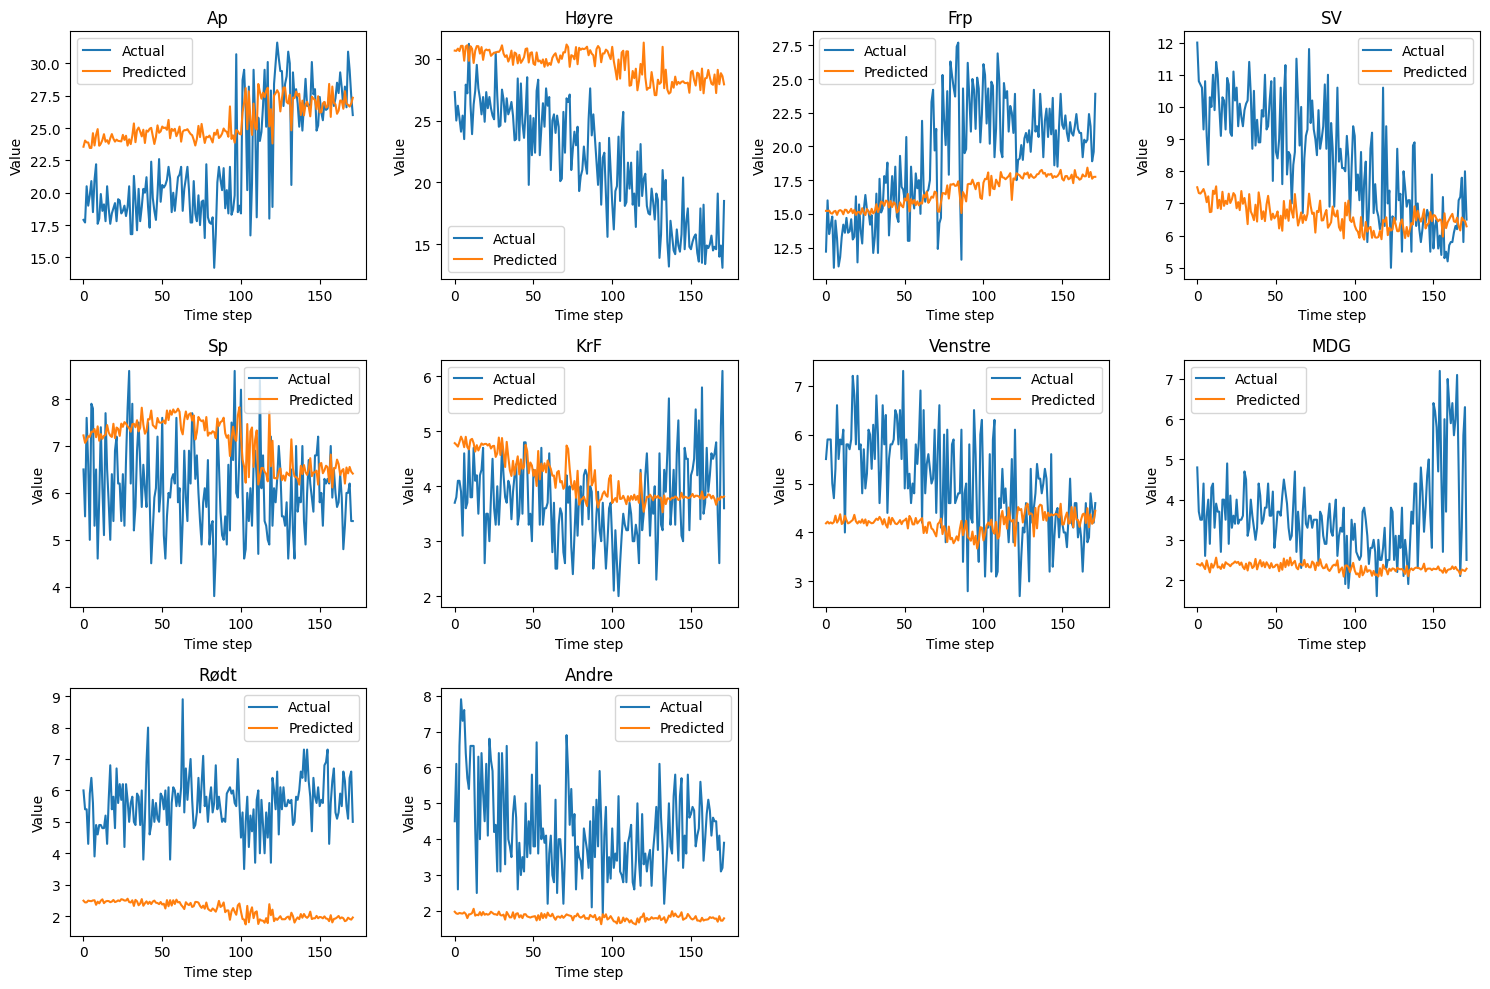

In [412]:
y_pred = model.predict(X_test)  # shape: (num_test, 9)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(df_en.columns):
    plt.subplot(3, 4, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(col)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()


In [448]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

n_features = 10       # you have 10 series
window_size = 20      # or 15–20 if you want a longer lookback

# Define model
model = Sequential([
    Input(shape=(window_size, n_features)),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.2),
    Dense(n_features),
    Lambda(lambda x: tf.nn.softmax(x) * 100)  # ensures outputs sum to 100
])

# Compile model
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Print model summary
model.summary()

#model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Train model
history = model.fit(
    train_dataset,      # assuming you have a tf.data.Dataset
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,610 (84.41 KB)

 Trainable params: 21,610 (84.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 53.4735 - mae: 5.2605 - val_loss: 16.2959 - val_mae: 2.8365 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 23.5977 - mae: 3.4085 - val_loss: 12.0340 - val_mae: 2.5522 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.3363 - mae: 2.9143 - val_loss: 11.0500 - val_mae: 2.4763 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.8316 - mae: 2.7059 - val_loss: 12.1845 - val_mae: 2.5396 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.2090 - mae: 2.5495 - val_loss: 11.5599 - val_mae: 2.5617 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.0114 - mae: 2.4168 - val_loss: 11.3693 - val_mae: 2.5032 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.9608 - mae: 2.3112 - val_loss: 11.7114 - val_mae: 2.5049 - learning_rate: 0.0010
Epoch

In [449]:
# Collect all batches from tf.data.Dataset into arrays
X_test, y_test = [], []
for X_batch, y_batch in val_dataset:  # or test_dataset if you split
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print("X_test shape:", X_test.shape)  # (num_test, window_size, 9)
print("y_test shape:", y_test.shape)  # (num_test, 9)


X_test shape: (172, 15, 10)
y_test shape: (172, 10)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


IndexError: index 10 is out of bounds for axis 1 with size 10

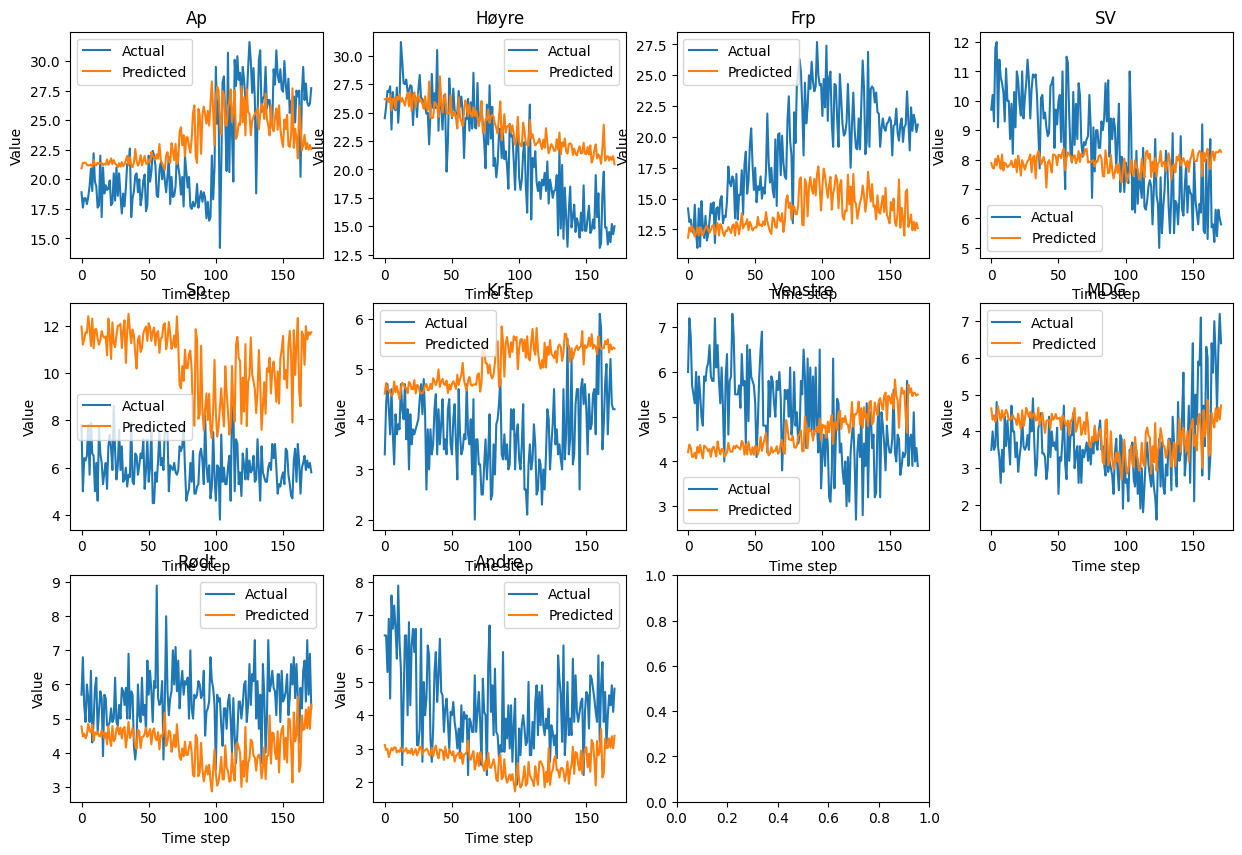

In [450]:
y_pred = model.predict(X_test)  # shape: (num_test, 9)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(df_en.columns):
    plt.subplot(3, 4, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(col)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()
